**Importar las funciones necesarias para aplicar los modelos**

In [5]:
import random
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import contractions
import seaborn as sns
from sklearn.metrics import confusion_matrix

**Descargar los recursos que ayudarán al desglose de las frases**

In [8]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Función que permite estandarizar y simplificar las frases**

In [13]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocesar_frase(frase):
    frase = frase.lower()  # Convertir a minúsculas
    frase = contractions.fix(frase)  # Expandir contracciones
    tokens = word_tokenize(frase)  # Tokenizar frase
    tokens = [palabra for palabra in tokens if palabra not in string.punctuation]
    tokens = [palabra for palabra in tokens if palabra not in stop_words]
    
    # Obtener las etiquetas gramaticales
    etiquetas = nltk.pos_tag(tokens)
    
    # Lematizar
    tokens_lemmatizados = [
        lemmatizer.lemmatize(palabra, obtener_etiqueta(etiqueta)) for palabra, etiqueta in etiquetas
    ]
    
    return ' '.join(tokens_lemmatizados)

**Seleccionar la frase de cada review**

In [16]:
def seleccionar_frase(oraciones_reseña, tiene_spoiler):
    frases_con_spoiler = [oracion for es_spoiler, oracion in oraciones_reseña if es_spoiler == 1]
    if tiene_spoiler and frases_con_spoiler:
        return random.choice(frases_con_spoiler)
    else:
        return random.choice([oracion for _, oracion in oraciones_reseña])

**Etiquetar cada palabra según corresponda**

In [19]:
def obtener_etiqueta(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

**Función que permite evaluar una frase ya dado el modelo**

In [21]:
def probar_frase(modelo, vectorizador, frase):  # Predecir una frase dada
    # Preprocesar la frase
    frase_procesada = preprocesar_frase(frase)
    
    # Vectorizar la frase
    X_nueva = vectorizador.transform([frase_procesada])
    
    # Predecir con el modelo
    prediccion = modelo.predict(X_nueva)
    
    # Mostrar el resultado
    if prediccion[0] == 1:
        print("La frase contiene un spoiler.")
    else:
        print("La frase no contiene un spoiler.")

**Definición del modelo a usar**

In [23]:
vectorizacion = 'tfidf'
tipo_modelo = 'logistic'
peso = {0: 1, 1: 1}


**Ruta y máximo de reseñas a considerar**

In [25]:
ruta_archivo = 'C:/Users/Daniel/Documents/Universidad/Semestre 10/Proyectos Estadísticos/goodreads_reviews_spoiler.json/goodreads_reviews_spoiler.json'
maximo_reseñas = 100000
tamaño_chunk = 1000

**Recorrido de la base de datos**

In [27]:
datos_reseñas = []
for chunk in pd.read_json(ruta_archivo, lines=True, chunksize=tamaño_chunk):
    for _, fila in chunk.iterrows():
        if len(datos_reseñas) >= maximo_reseñas:
            break
        
        frase_clave = seleccionar_frase(fila['review_sentences'], fila['has_spoiler'])
        etiqueta = fila['has_spoiler']
        datos_reseñas.append((frase_clave, etiqueta))
    
    if len(datos_reseñas) >= maximo_reseñas:
        break

**Creación Dataframe y su estandarización**

In [33]:
df_reseñas = pd.DataFrame(datos_reseñas, columns=['texto', 'etiqueta'])
df_reseñas['texto'] = df_reseñas['texto'].apply(preprocesar_frase)

**Distribución etiquetas**

In [41]:
print("Distribución de etiquetas antes del muestreo:")
print(df_reseñas['etiqueta'].value_counts())

Distribución de etiquetas antes del muestreo:
etiqueta
False    93582
True      6418
Name: count, dtype: int64


**Obtener muestra para que sea equilibrada**

In [44]:
minimo_conteo = df_reseñas['etiqueta'].value_counts().min()
tamaño_muestra = min(minimo_conteo * 2, maximo_reseñas)
df_muestra = df_reseñas.groupby('etiqueta', group_keys=False).apply(lambda x: x.sample(int(tamaño_muestra * 0.5), random_state=27))

C:\Users\Daniel\AppData\Local\Temp\ipykernel_16360\3923183168.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_muestra = df_reseñas.groupby('etiqueta', group_keys=False).apply(lambda x: x.sample(int(tamaño_muestra * 0.5), random_state=27))


**Selección de forma de vectorización**

In [47]:
if vectorizacion == 'tfidf':
    vectorizador = TfidfVectorizer(max_features=10000)
elif vectorizacion == 'bow':
    vectorizador = CountVectorizer(max_features=10000)

**Vectorización**

In [51]:
X = vectorizador.fit_transform(df_muestra['texto'])
y = df_muestra['etiqueta']

**Creación grupos de testeo y entrenamiento**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=27)

**Selección modelo**

In [63]:
if tipo_modelo == 'svm':
    modelo = SVC(C=1.0, kernel='linear', class_weight=peso, random_state=27)
elif tipo_modelo == 'logistic':
    modelo = LogisticRegression(class_weight=peso, max_iter=1000, random_state=27)

**Ajuste modelo**

In [66]:
modelo.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 1}, max_iter=1000, random_state=27)

**Reporte de clasificación**

In [69]:
y_pred = modelo.predict(X_test)
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Reporte de Clasificación:
               precision    recall  f1-score   support

       False       0.72      0.70      0.71       963
        True       0.71      0.73      0.72       963

    accuracy                           0.72      1926
   macro avg       0.72      0.72      0.72      1926
weighted avg       0.72      0.72      0.72      1926



**Métrica F1 Beta Score**

In [72]:
f1_beta = fbeta_score(y_test, y_pred, beta=2)
print("\nF1 Beta Score:", f1_beta)


F1 Beta Score: 0.7269723254853366


**Curva ROC**

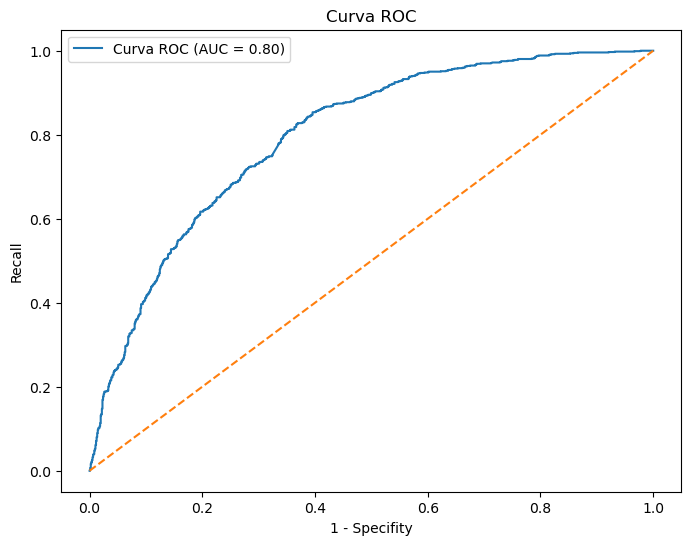

In [75]:
if tipo_modelo == 'svm':
    y_proba = modelo.decision_function(X_test)
elif tipo_modelo == 'logistic':
    y_proba = modelo.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Recall')
plt.title('Curva ROC')
plt.legend()
plt.show()

**Curva PR**


AUC Precisión-Recall: 0.7649971639932437


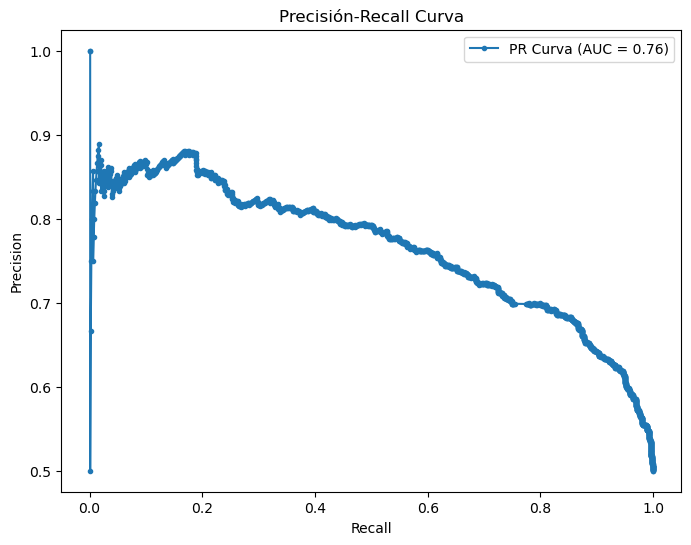

In [78]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("\nAUC Precisión-Recall:", pr_auc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curva (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precisión-Recall Curva')
plt.legend()
plt.show()